In [1]:
from scipy.io import loadmat
import torch

%load_ext autoreload
%autoreload 2
%matplotlib inline

from dstft.loss import entropy_loss
from dstft import DSTFT

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
mat = loadmat('../data/fan_flutter.mat')['x']
x = torch.from_numpy(mat).float().to(device)[:, 4_000:10_000]

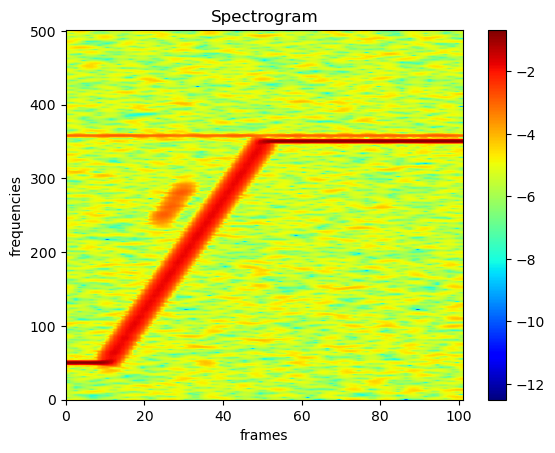

In [3]:
dstft = DSTFT(x, win_length=500, support=1_000, stride=50, win_requires_grad=False, stride_requires_grad=False, win_p=None, stride_p=None)
spec, *_ =dstft(x)
dstft.print(spec, weights=False, wins=False, bar=True)

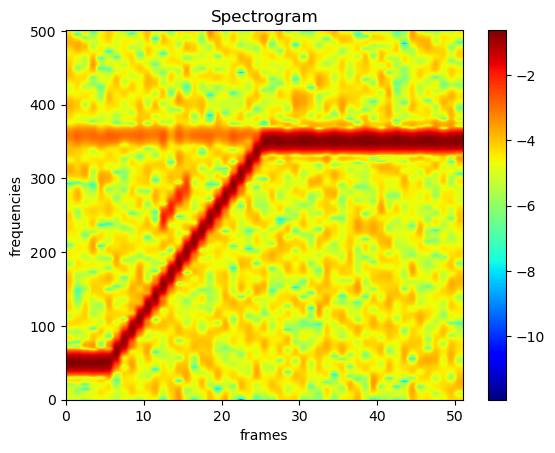

In [4]:
dstft = DSTFT(x, win_length=100, support=1_000, stride=100, win_requires_grad=False, stride_requires_grad=False, win_p=None, stride_p=None)
spec, stft, real, imag, phase = dstft(x)
dstft.print(spec, weights=False, wins=False, bar=True)

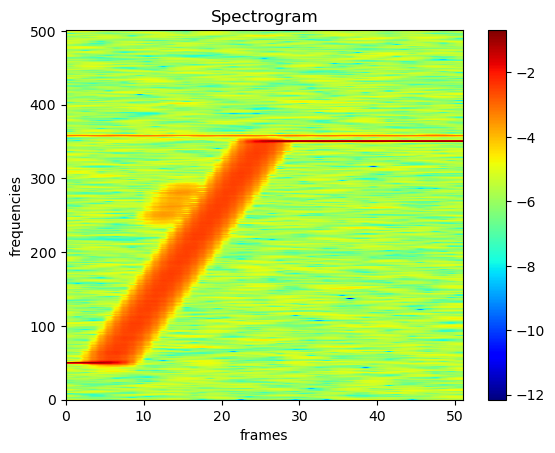

In [5]:
dstft = DSTFT(x, win_length=1_000, support=1_000, stride=100, win_requires_grad=False, stride_requires_grad=False, win_p=None, stride_p=None)
spec, stft, real, imag, phase = dstft(x)
dstft.print(spec, weights=False, wins=False, bar=True)

Single window length

Epoch 00019: reducing learning rate of group 0 to 1.0000e+01.
Epoch 00029: reducing learning rate of group 0 to 1.0000e+00.
Epoch 00039: reducing learning rate of group 0 to 1.0000e-01.
38


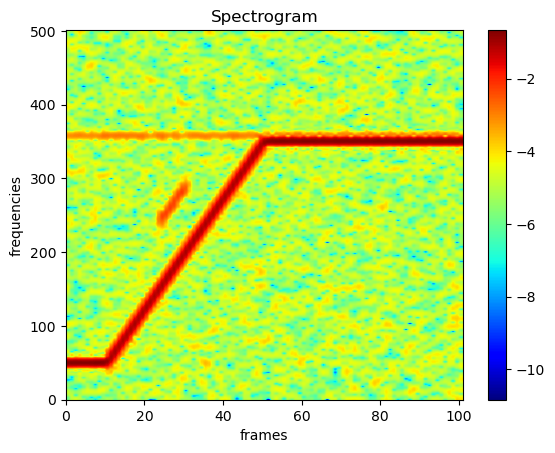

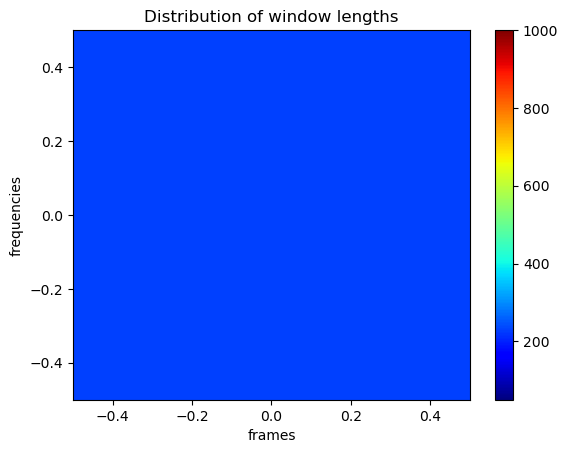

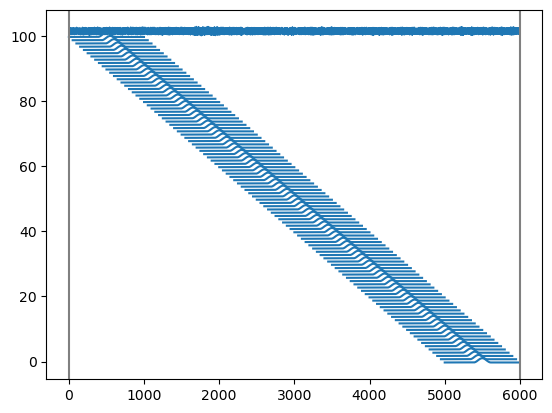

In [6]:
dstft = DSTFT(x, win_length=577, support=1_000, stride=50, win_requires_grad=True, stride_requires_grad=False, win_p=None, stride_p=None)
params = [{'params': dstft.win_length,    'lr': 100.0}, ] 
opt = torch.optim.Adam(params)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.1, patience=9, verbose=True)

for epoch in range(1_000):
    opt.zero_grad()    
    spec, *_ = dstft(x)
    err = entropy_loss(spec)
    err.backward()    
    opt.step()
    sch.step(err)
    
    if opt.param_groups[0]['lr'] < 1:
        break
    
print(epoch)
dstft.print(spec, x, bar=True)

Time-varying window length

Epoch 00034: reducing learning rate of group 0 to 1.0000e+01.
Epoch 00044: reducing learning rate of group 0 to 1.0000e+00.
Epoch 00054: reducing learning rate of group 0 to 1.0000e-01.
53


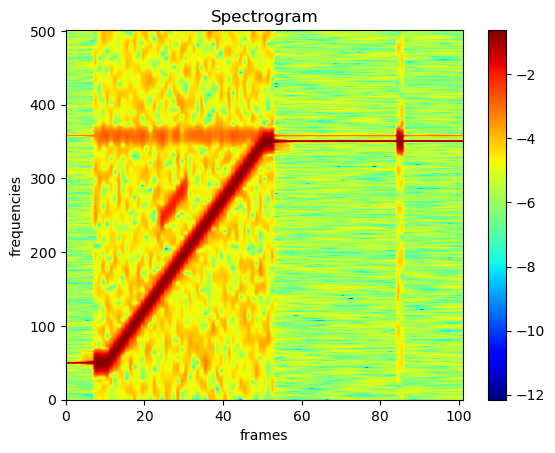

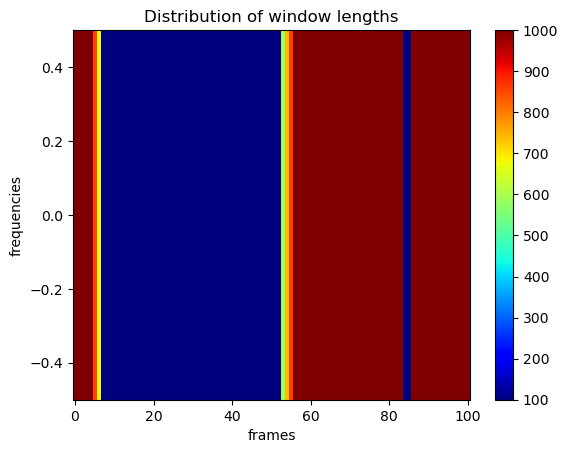

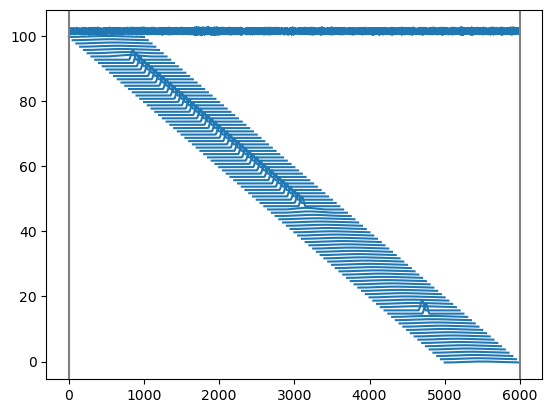

In [7]:
dstft = DSTFT(x, win_length=577, support=1_000, stride=50, win_requires_grad=True, stride_requires_grad=False, win_p='t', win_min=100)
params = [{'params': dstft.win_length, 'lr': 100.0}, ] 
opt = torch.optim.Adam(params)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.1, patience=9, verbose=True)

for epoch in range(1_000):
    opt.zero_grad()    
    spec, *_ = dstft(x)
    err = entropy_loss(spec)
    err.backward()
    opt.step()
    sch.step(err)
    
    if opt.param_groups[0]['lr'] < 1:
        break
    
print(epoch)
dstft.print(spec, x, bar=True)

Epoch 00044: reducing learning rate of group 0 to 1.0000e+01.
Epoch 00054: reducing learning rate of group 0 to 1.0000e+00.
Epoch 00064: reducing learning rate of group 0 to 1.0000e-01.
63


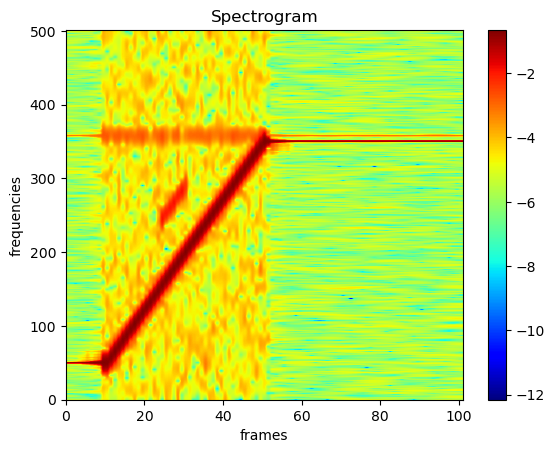

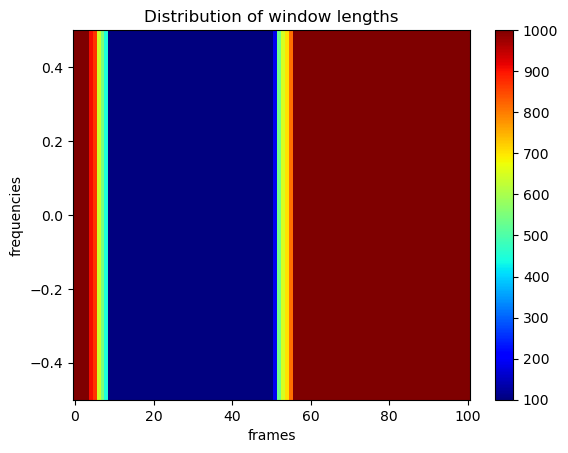

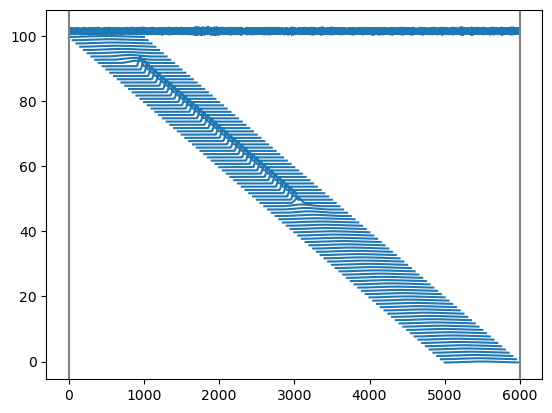

In [8]:
dstft = DSTFT(x, win_length=577, support=1_000, stride=50, win_requires_grad=True, stride_requires_grad=False, win_p='t', win_min=100)
params = [{'params': dstft.win_length, 'lr': 100.0}, ] 
opt = torch.optim.Adam(params)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.1, patience=9, verbose=True)

for epoch in range(1_000):
    opt.zero_grad()    
    spec, *_ = dstft(x)
    err = entropy_loss(spec) + 0.001 * (dstft.actual_win_length.diff(dim=1).pow(2) + torch.finfo(x.dtype).eps).sqrt().mean()
    err.backward()
    opt.step()
    sch.step(err)
    
    if opt.param_groups[0]['lr'] < 1:
        break

print(epoch)
dstft.print(spec, x, bar=True)

Frequency-varying window length

Epoch 00039: reducing learning rate of group 0 to 1.0000e+01.
Epoch 00051: reducing learning rate of group 0 to 1.0000e+00.
Epoch 00061: reducing learning rate of group 0 to 1.0000e-01.
60


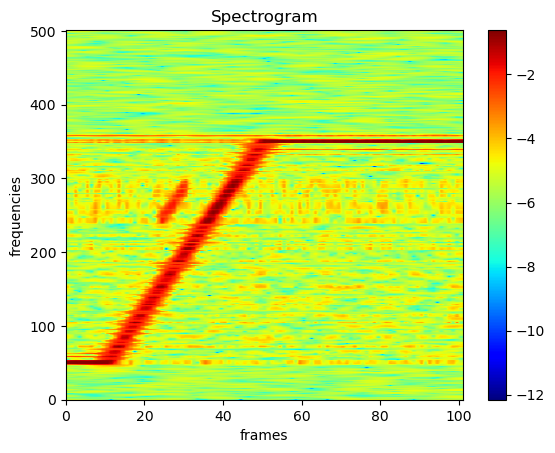

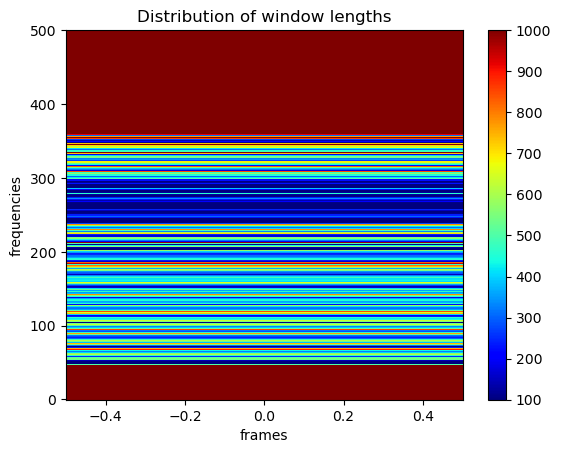

In [9]:
dstft = DSTFT(x, win_length=577, support=1_000, stride=50, win_requires_grad=True, stride_requires_grad=False, win_p='f', win_min=100)
params = [{'params': dstft.win_length,    'lr': 100.0}, ] 
opt = torch.optim.Adam(params)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.1, patience=9, verbose=True)

for epoch in range(1_000):
    opt.zero_grad()
    spec, *_ = dstft(x)
    err = entropy_loss(spec)
    err.backward()
    opt.step()
    sch.step(err)
    
    if opt.param_groups[0]['lr'] < 1:
        break
    
print(epoch)
dstft.print(spec, x, wins=False, bar=True)


Epoch 00012: reducing learning rate of group 0 to 1.0000e+01.
Epoch 00126: reducing learning rate of group 0 to 1.0000e+00.
Epoch 00160: reducing learning rate of group 0 to 1.0000e-01.
159


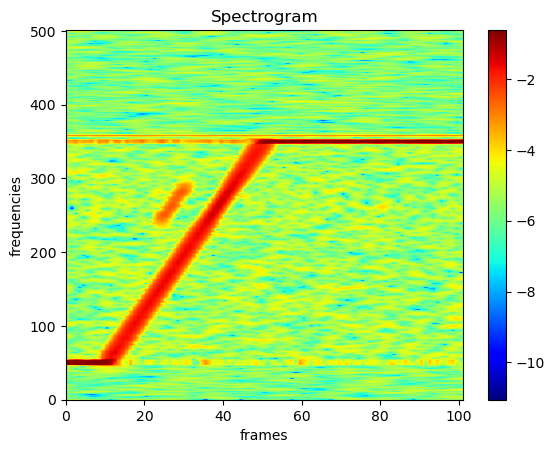

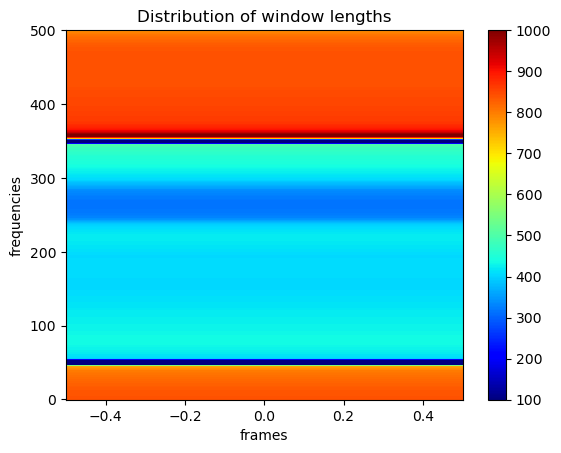

In [10]:
dstft = DSTFT(x, win_length=577, support=1_000, stride=50, win_requires_grad=True, stride_requires_grad=False, win_p='f', win_min=100)
params = [{'params': dstft.win_length, 'lr': 100.0},  ]
opt = torch.optim.Adam(params)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.1, patience=9, verbose=True)

for epoch in range(1_000):
    opt.zero_grad()
    spec, *_ = dstft(x)
    err = entropy_loss(spec) + 0.01 * (dstft.actual_win_length.diff(dim=0).pow(2) + torch.finfo(x.dtype).eps).sqrt().mean()
    err.backward()
    opt.step()
    sch.step(err)
    
    if opt.param_groups[0]['lr'] < 1:
        break
    
print(epoch)
dstft.print(spec, x, wins=False, bar=True)

Time-and-frequency-varying window length

Epoch 00065: reducing learning rate of group 0 to 1.0000e+01.
Epoch 00085: reducing learning rate of group 0 to 1.0000e+00.
Epoch 00095: reducing learning rate of group 0 to 1.0000e-01.
94


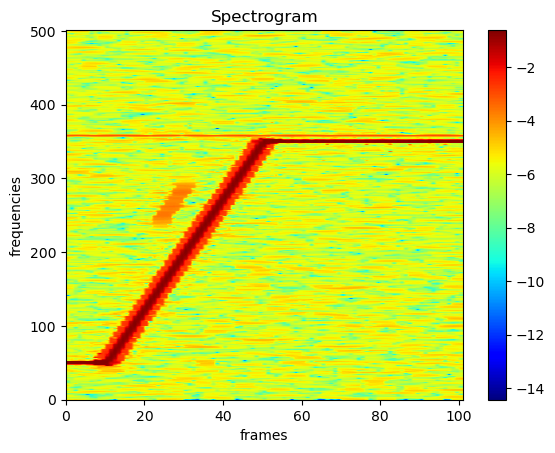

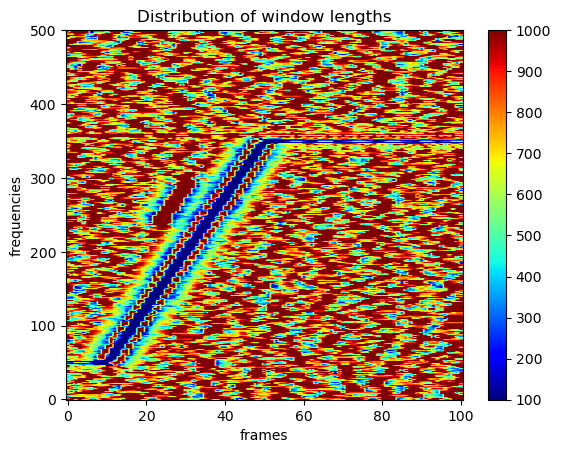

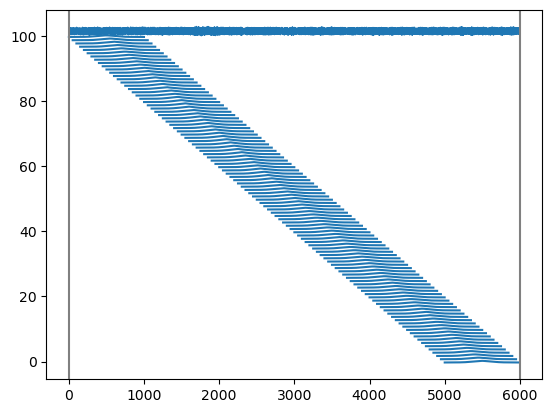

In [11]:
dstft = DSTFT(x, win_length=577, support=1_000, stride=50, win_requires_grad=True, stride_requires_grad=False, win_p='tf', win_min=100)
params = [{'params': dstft.win_length, 'lr': 100.0},  ] 
opt = torch.optim.Adam(params)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.1, patience=9, verbose=True)

for epoch in range(1_000):
    opt.zero_grad()
    spec, *_ = dstft(x)
    err = entropy_loss(spec)
    err.backward()
    opt.step()
    sch.step(err)
    
    if opt.param_groups[0]['lr'] < 1:
        break
    
print(epoch)
dstft.print(spec, x, bar=True)

Epoch 00112: reducing learning rate of group 0 to 1.0000e+01.
Epoch 00112: reducing learning rate of group 1 to 1.0000e-01.
Epoch 00150: reducing learning rate of group 0 to 1.0000e+00.
Epoch 00150: reducing learning rate of group 1 to 1.0000e-02.
Epoch 00174: reducing learning rate of group 0 to 1.0000e-01.
Epoch 00174: reducing learning rate of group 1 to 1.0000e-03.
173


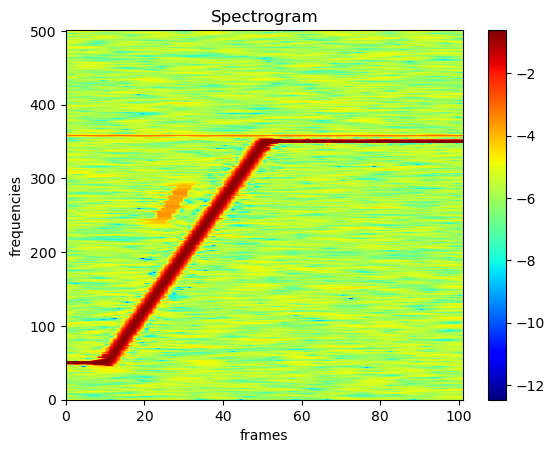

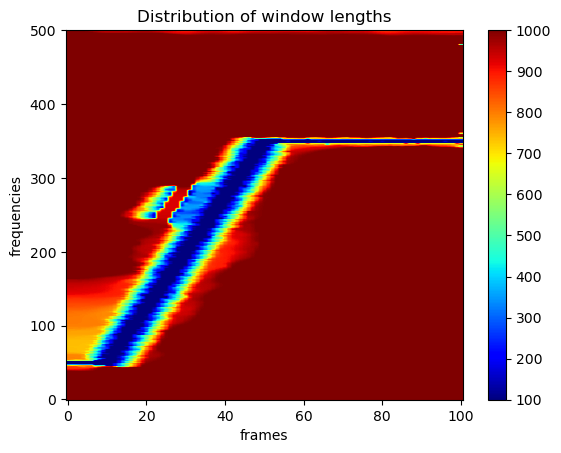

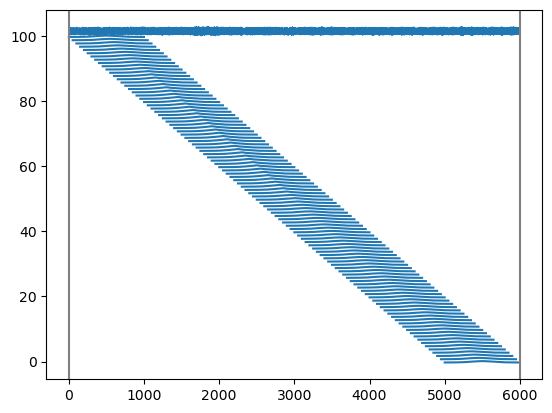

In [12]:
dstft = DSTFT(x, win_length=577, support=1_000, stride=50, win_requires_grad=True, stride_requires_grad=False, win_p='tf', win_min=100)
params = [{'params': dstft.win_length,'lr': 100.0}, {'params': dstft.strides,    'lr': 1.0}] 
opt = torch.optim.Adam(params)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.1, patience=9, verbose=True)

for epoch in range(1_000):
    opt.zero_grad()
    spec, *_ = dstft(x)
    err = entropy_loss(spec) + 0.01 * (dstft.actual_win_length.diff(dim=0)[:, :-1].pow(2) + dstft.actual_win_length.diff(dim=1)[:-1].pow(2) + torch.finfo(x.dtype).eps).sqrt().mean()
    err.backward()
    opt.step()
    sch.step(err)
    
    if opt.param_groups[0]['lr'] < 1:
        break
    
print(epoch)
dstft.print(spec, x, bar=True)